# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [317]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_style("darkgrid")

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [318]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

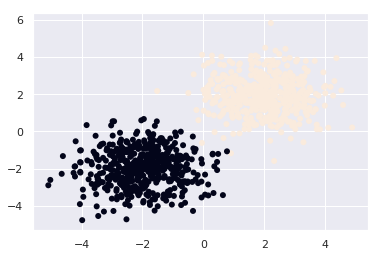

In [361]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none');

Define a **logistic regression** for debugging. 

In [320]:
#net = Sequential()
#net.add(Linear(2, 2))
#net.add(LogSoftMax())

criterion = ClassNLLCriterion()

#print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [321]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [322]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

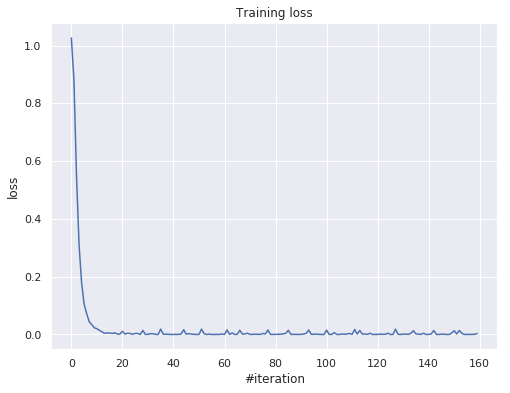

Current loss: 0.003228


In [323]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

Feeding to the input of dense layers we need to reshape it appropriately. If there are convolution layers in the network architecture, we put 'Flatten' layer between them and fully-connected ones. But in our case, right after the input layer, a dense layer follows. Putting a 'Flatten' layer between them likely is an extra thing - calculating of gradients propagation here does not make sense.
So, we are just specifying in the dataset loader that the data must be flattened

In [324]:
import mnist

One-hot encode the labels first.

In [325]:
# Your code goes here. ################################################
def one_hot_encode(labels_list, max_number):
    """
    - `labels_list` (if sorted) must be sequantial,
    starts with 0 and increments by 1
    - `max_number` must be at least the number of
    classes (can be greater but not less)
    """
    samples_number = len(labels_list)
    code = np.zeros((samples_number, max_number))
    code[np.arange(samples_number), labels_list] = 1
    
    return code

In [326]:
def net_stencil(activations, 
                bn=False, 
                do=[False, False], 
                inc = [1,1], 
                logsoftmax=True):
    """
    activations : array-like - an object containing 2
                  activation layers
    bn    -    add batch normalization layer if the value is true
    do    -    add dropout if the value is true
    inc   -    increace number of neurons by these factors in
               corresponding fully-connected layers
               
    logsoftmax - add LogSoftMax layer 
    """
    activation1, activation2 = activations
    
    net = Sequential()
    net.add(Linear(784, 
                   inc[0] * 784 // 8, 
                   bias=not bn))
    if do[0]:
        net.add(Dropout())
    if bn:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(inc[0] * 784 // 8))
    net.add(activation1)
    net.add(Linear(inc[0] * 784 // 8, 
                   inc[1] * 784 // 8 // 4, 
                   bias=not bn))
    if do[1]:
        net.add(Dropout())
    if bn:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(inc[1] * 784 // 8 // 4))
    net.add(activation2)
    net.add(Linear(inc[1] * 784 // 8 // 4, 10))
    if logsoftmax:
        net.add(LogSoftMax())
    
    return net

What configs to choose for adam? - check it [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) for example

In [327]:
class Experiment:
    """
    Train and test your network perfomance on a dataset
    in a similar way we did it on seminar 2
    """
    n_classes = 10
    n_epoch = 20
    batch_size = 128
    
    sgdmom_configs = {'learning_rate' : 1e-1,
                   'momentum':       0.9}
    
    adam_configs = {'learning_rate' : 1e-3, 
                    'beta1': 0.9, 
                    'beta2': 0.999, 
                    'epsilon': 1e-8}
    
    data = mnist.load_dataset(flatten=True)
    
    def __init__(self, GD="sgd", performance=True, **kwargs):
        self.performance = performance
        self.criterion = kwargs.setdefault('crit', ClassNLLCriterion())
        
        if GD == "adam":
            self.optimizer = adam_optimizer
            self.optimizer_config = self.adam_configs
        elif GD == "sgd":
            self.optimizer = sgd_momentum
            self.optimizer_config = self.sgdmom_configs
        else: 
            raise ValueError("Wrong optimizer name")

    def run(self, net):
        loss_history = []
        val_score = []
        test_score = []
        epoch_time = []
        
        X_train, Y_train,\
        X_val, Y_val,\
        X_test, Y_test = self.data
       
        if not isinstance(self.criterion, ClassContrastiveCriterion):
            Y_train = one_hot_encode(Y_train, self.n_classes)
            Y_val = one_hot_encode(Y_val, self.n_classes)
            Y_test = one_hot_encode(Y_test, self.n_classes)
        
        optimizer_state = {}
        
        start_time = time()
        for _ in range(self.n_epoch):
            net.train()
            for x_batch, y_batch in get_batches((X_train, Y_train), 
                                                self.batch_size):
                
                net.zeroGradParameters()

                # Forward
                predictions = net.forward(x_batch)
                loss = self.criterion.forward(predictions, y_batch)

                # Backward
                dp = self.criterion.backward(predictions, y_batch)
                net.backward(x_batch, dp)

                # Update weights
                self.optimizer(net.getParameters(), 
                          net.getGradParameters(), 
                          self.optimizer_config,
                          optimizer_state)      

                loss_history.append(loss)
            
            if self.performance:
                net.evaluate()
                val_accuracy = []
                for x_batch, y_batch in get_batches((X_val, Y_val), 
                                                    self.batch_size):
                    y_batch = np.where(y_batch > 0)[1]
                    y_pred = net.forward(x_batch).argmax(1)
                    val_accuracy.append(np.mean(y_pred == y_batch))

                test_accuracy = []
                for x_batch, y_batch in get_batches((X_test, Y_test), 
                                                    self.batch_size):
                    y_batch = np.where(y_batch > 0)[1]
                    y_pred = net.forward(x_batch).argmax(1)
                    test_accuracy.append(np.mean(y_pred == y_batch))

                val_score.append(np.mean(val_accuracy))
                test_score.append(np.mean(test_accuracy))
                
            epoch_time.append(time() - start_time)
            
        if self.performance:    
            return loss_history, val_score,\
                   test_score, epoch_time

In [328]:
lossize = 50000 // test.batch_size + (50000 % test.batch_size > 0) * 1
lossize *= test.n_epoch

---
- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***

In [329]:
test = Experiment("sgd")

names = np.array([ReLU(), ELU(), LeakyReLU(), SoftPlus()])
objectives = np.repeat(names.reshape(-1,1), 2, axis=1)
for name in names:
    name = str(name)
names = names.astype(str)

loss = np.empty((8,lossize))
vscore = np.empty((8, test.n_epoch))
tscore = np.empty_like(vscore)
span = np.empty_like(vscore)
for i,activations in enumerate(objectives):
    net = net_stencil(activations)
    loss[i], vscore[i], tscore[i], span[i] = test.run(net)

[running mean](https://stackoverflow.com/questions/13728392/moving-average-or-running-mean) - the second first answer

In [330]:
def running_mean(signal,window_width=80):
    signal = np.convolve(signal, np.ones(window_width)\
                         / window_width, mode='valid')
    return signal

In [331]:
cmap = "red orange green blue violet brown gold grey".split()

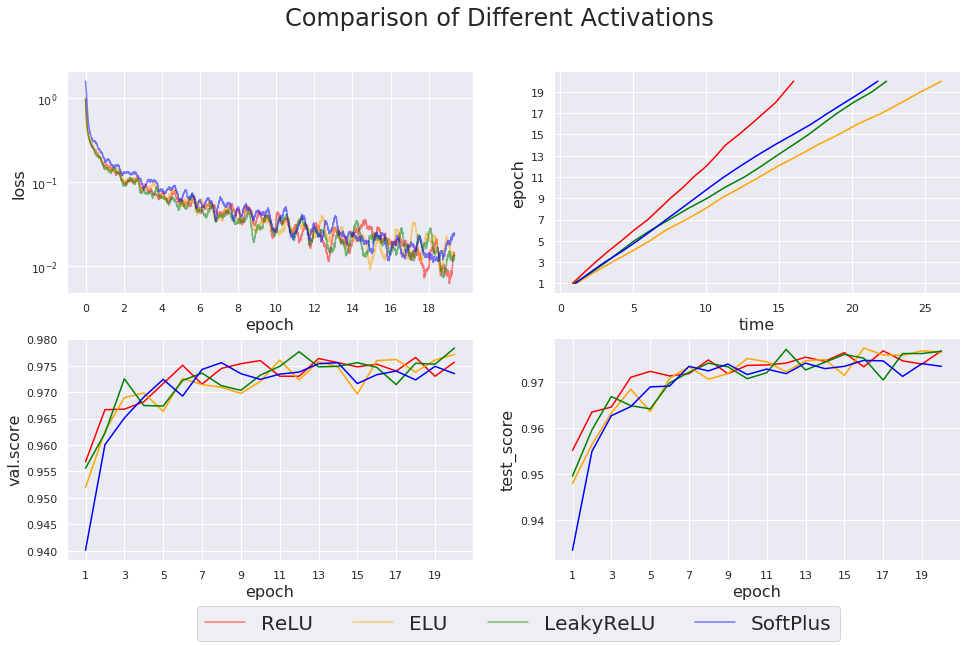

In [332]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
x_loss = np.arange(0,21,2)
epochs = np.arange(1,21)
pos_loss = np.arange(0,lossize,800)
pos_rest = np.arange(1,21,2)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(pos_loss)
ax[0,0].set_xticklabels(x_loss)
ax[0,1].set_yticks(pos_rest)
ax[1,0].set_xticks(pos_rest)
ax[1,1].set_xticks(pos_rest)
lines = []
xlabel = "epoch time epoch epoch".split()
ylabel = "loss epoch val.score test_score".split()
for i in range(4):
    ax[i // 2,i % 2].set_xlabel(xlabel[i],fontsize=16)
    ax[i // 2,i % 2].set_ylabel(ylabel[i],fontsize=16)
    line, = ax[0,0].plot(running_mean(loss[i]), c=cmap[i],alpha=0.5)
    lines.append(line)
    ax[0,1].plot(span[i],epochs,c=cmap[i])
    ax[1,0].plot(epochs,vscore[i],c=cmap[i])
    ax[1,1].plot(epochs,tscore[i],c=cmap[i])
fig.legend(lines, names, ncol=5, fontsize=20, loc=8, bbox_to_anchor=(.45,-.01))
fig.suptitle("Comparison of Different Activations",size=24);

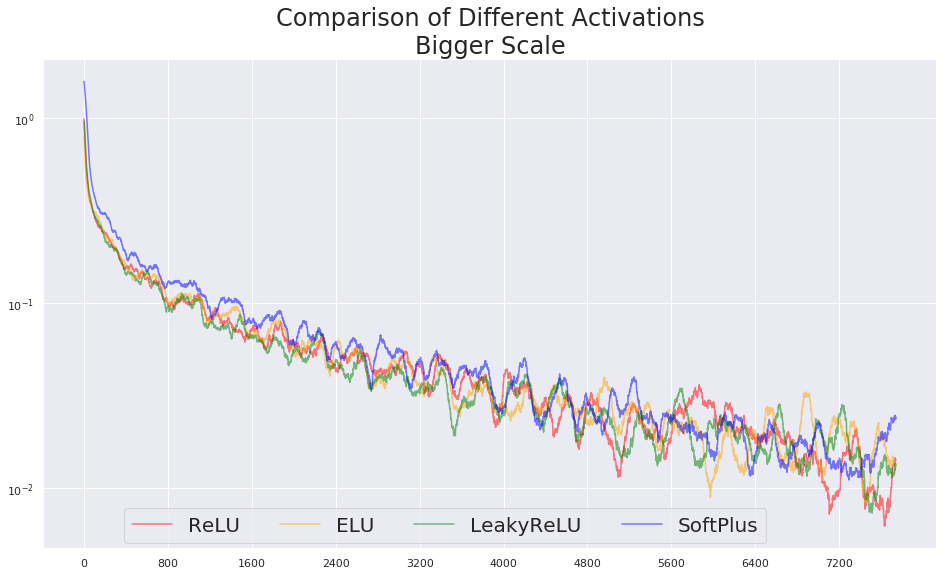

In [335]:
x_loss = np.arange(0,21,2)
pos_loss = np.arange(0,lossize,800)
plt.figure(figsize=(16,9))
plt.yscale('log')
plt.xticks(pos_loss)
#plt.xticklabels(x_loss)
lines = []
for i in range(4):
    line, = plt.plot(running_mean(loss[i]), c=cmap[i],alpha=0.5)
    lines.append(line)
plt.legend(lines, names, ncol=5, fontsize=20, loc=8, bbox_to_anchor=(.45,-.01))
plt.title("Comparison of Different Activations\nBigger Scale",size=24);

**In my biased opinion Leaky ReLU performs the best. ReLU also does well. They are quite fast at training and good at predicting. Their simple nature also makes them favorable. SoftPlus has shown to be the best operating on the new data (test dataset), but it is the slowest in training. ELU is a kind of average guy and since inconspicuous**

---
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

In [336]:
activations = [LeakyReLU(),LeakyReLU()]
net = net_stencil(activations,bn=True)
loss[4], vscore[4], tscore[4], span[4] = test.run(net)

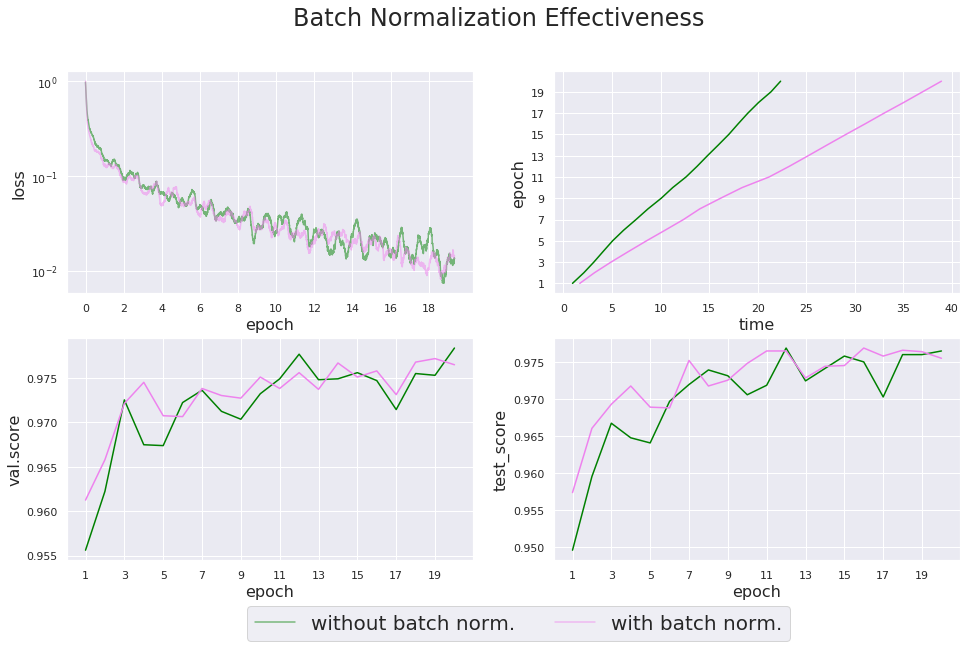

In [337]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
x_loss = np.arange(0,21,2)
epochs = np.arange(1,21)
pos_loss = np.arange(0,lossize,800)
pos_rest = np.arange(1,21,2)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(pos_loss)
ax[0,0].set_xticklabels(x_loss)
ax[0,1].set_yticks(pos_rest)
ax[1,0].set_xticks(pos_rest)
ax[1,1].set_xticks(pos_rest)
lines = []
for i in [2,4]:
    line, = ax[0,0].plot(running_mean(loss[i]), c=cmap[i],alpha=0.5)
    lines.append(line)
    ax[0,1].plot(span[i],epochs,c=cmap[i])
    ax[1,0].plot(epochs,vscore[i],c=cmap[i])
    ax[1,1].plot(epochs,tscore[i],c=cmap[i])
fig.legend(lines, ["without batch norm.","with batch norm."], ncol=5, 
                   fontsize=20, loc=8, bbox_to_anchor=(.45,-.01))
fig.suptitle("Batch Normalization Effectiveness",size=24)
for i in range(4):
    ax[i // 2,i % 2].set_xlabel(xlabel[i],fontsize=16)
    ax[i // 2,i % 2].set_ylabel(ylabel[i],fontsize=16)

***The network with batch normalization layer is superior to the one which does not have this layer in all the results (the improvement effect is arguable, it seems to depend on the parameters initialization - I mean, for many of cell calls, you can get the results when batch norm. does obviously much better. In some cases, the plots show that it is almost no difference whether there is a batch norm. layer or not), but the time it took to train the network and predict the classes of the validation and test data samples***

---
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***

In [338]:
net = net_stencil(activations,bn=True)
test = Experiment("adam")
loss[5], vscore[5], tscore[5], span[5] = test.run(net)

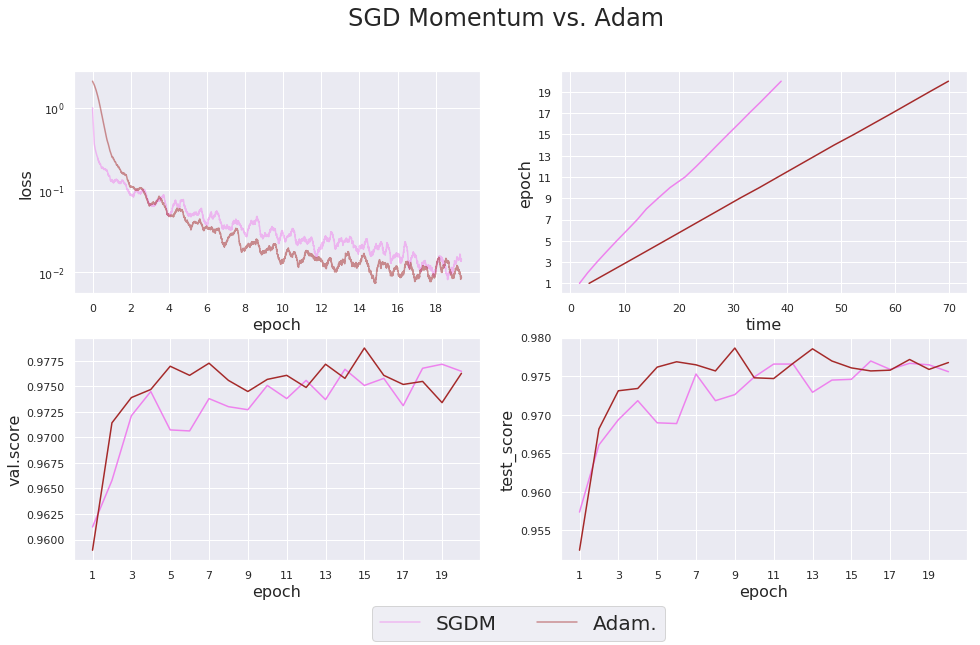

In [339]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
x_loss = np.arange(0,21,2)
epochs = np.arange(1,21)
pos_loss = np.arange(0,lossize,800)
pos_rest = np.arange(1,21,2)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(pos_loss)
ax[0,0].set_xticklabels(x_loss)
ax[0,1].set_yticks(pos_rest)
ax[1,0].set_xticks(pos_rest)
ax[1,1].set_xticks(pos_rest)
lines = []
for i in [4,5]:
    line, = ax[0,0].plot(running_mean(loss[i]), c=cmap[i],alpha=0.5)
    lines.append(line)
    ax[0,1].plot(span[i],epochs,c=cmap[i])
    ax[1,0].plot(epochs,vscore[i],c=cmap[i])
    ax[1,1].plot(epochs,tscore[i],c=cmap[i])
fig.legend(lines, ["SGDM","Adam."], ncol=5, 
                   fontsize=20, loc=8, bbox_to_anchor=(.45,-.01))
fig.suptitle("SGD Momentum vs. Adam", size=24)
for i in range(4):
    ax[i // 2,i % 2].set_xlabel(xlabel[i],fontsize=16)
    ax[i // 2,i % 2].set_ylabel(ylabel[i],fontsize=16)

***The network trained by Adam optimizer performes slightly better. This can be seen from validation score plot - lower left. On the test score graph the improvement is not significant. Also, we can conclude from the loss graph that Adam is likely better in searching global minimum of the loss function.***

---
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***

In [340]:
test = Experiment("sgd")
net = net_stencil(activations,inc=[16,4])
loss[6], vscore[6], tscore[6], span[6] = test.run(net)
net = net_stencil(activations,do=[True,True], inc=[16,4])
loss[7], vscore[7], tscore[7], span[7] = test.run(net)

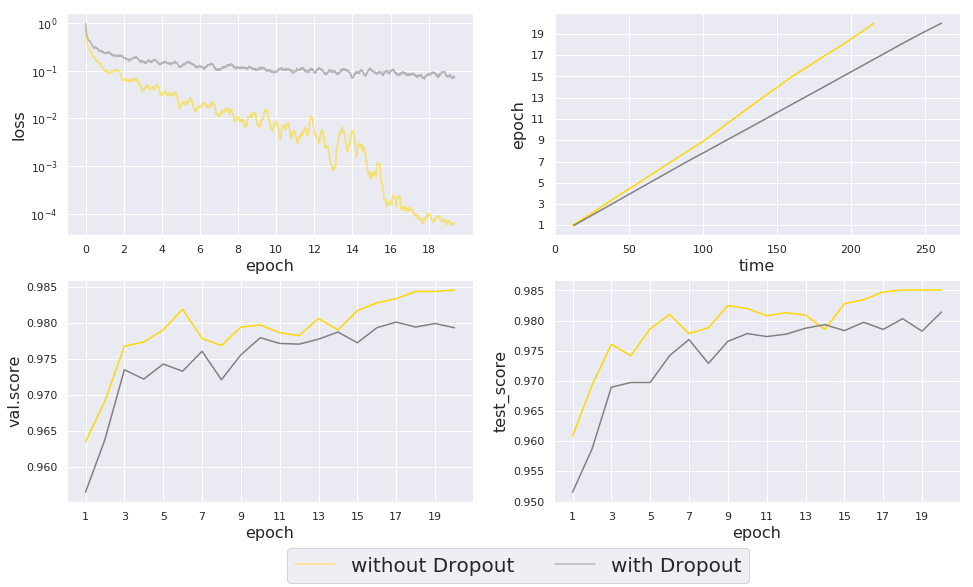

In [341]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
x_loss = np.arange(0,21,2)
epochs = np.arange(1,21)
pos_loss = np.arange(0,lossize,800)
pos_rest = np.arange(1,21,2)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(pos_loss)
ax[0,0].set_xticklabels(x_loss)
ax[0,1].set_yticks(pos_rest)
ax[1,0].set_xticks(pos_rest)
ax[1,1].set_xticks(pos_rest)
lines = []
for i in [6,7]:
    line, = ax[0,0].plot(running_mean(loss[i]), c=cmap[i],alpha=0.5)
    lines.append(line)
    ax[0,1].plot(span[i],epochs,c=cmap[i])
    ax[1,0].plot(epochs,vscore[i],c=cmap[i])
    ax[1,1].plot(epochs,tscore[i],c=cmap[i])
fig.legend(lines, ["without Dropout","with Dropout"], ncol=5, 
                   fontsize=20, loc=8, bbox_to_anchor=(.45,-.01))
fig.suptitle("", size=24)
for i in range(4):
    ax[i // 2,i % 2].set_xlabel(xlabel[i],fontsize=16)
    ax[i // 2,i % 2].set_ylabel(ylabel[i],fontsize=16)

***Inserting dropout laeyrs has lead to poor results. Probably, in the case of a greater width of dense layers or deeper networks the situation would be the opposite (but it takes a lot of time to train handcrafted networks in python on cpu). Also, I didn't tune the probability of neuron to be dropped out***

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

In [342]:
import scipy.spatial

In [358]:
def plot_dists(net, embeddings, labels, criterion_name):
    #compute pairwise distances
    d = scipy.spatial.distance_matrix(embeddings,embeddings)
    #extract distances for the 'positive pairs' (same class), 
    #extract distances for the 'negarite pairs' (different classes), 
    a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
    b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
    #labels
    c = np.zeros((len(labels), len(labels)))
    c[a==b]=1
    pind = np.triu(c, k=1)

    c = np.zeros((len(labels), len(labels)))
    c[a!=b]=1
    nind =  np.triu(c, k=1)

    print(np.sum(pind), np.sum(nind))


    pd = d[pind == 1]
    nd = d[nind == 1]

    plt.figure(figsize=(16,9))
    hp,_,_ = plt.hist(pd, 
                      bins=100, 
                      color='green', 
                      alpha = 0.3, 
                      weights = np.ones(len(pd))/len(pd), 
                      label = 'distances for positive pairs')

    hn,_,_ = plt.hist(nd, 
                      bins=100, 
                      color='red', 
                      alpha = 0.3, 
                      weights = np.ones(len(nd))/len(nd),
                      label = 'distances for negative pairs')
    
    plt.legend(loc='best')
    plt.title("Distance Distribution for %s Criterion" % criterion_name,fontsize=20)
    
    bhattacharyya = np.sum(np.sqrt(hp*hn))
    print("bhattacharyya coefficient =", bhattacharyya)

In [353]:
X_val, Y_val = mnist.load_dataset(flatten=True)[2:4]
indices = np.arange(len(X_val))
np.random.shuffle(indices)
take_N = 1000 # on my laptop the entire dataset gives memory error
X_val, labels = X_val[:take_N], Y_val[:take_N]

In [354]:
net = net_stencil(activations, bn=True, logsoftmax=False)
print(net)
test = Experiment(performance=False, 
                  crit=ClassContrastiveCriterion(M=10))
test.run(net)
embeddings = net.forward(X_val)

Linear 784 -> 98
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 98 -> 24
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 24 -> 10



49715.0 449785.0
bhattacharyya coefficient = 0.7631759729371504


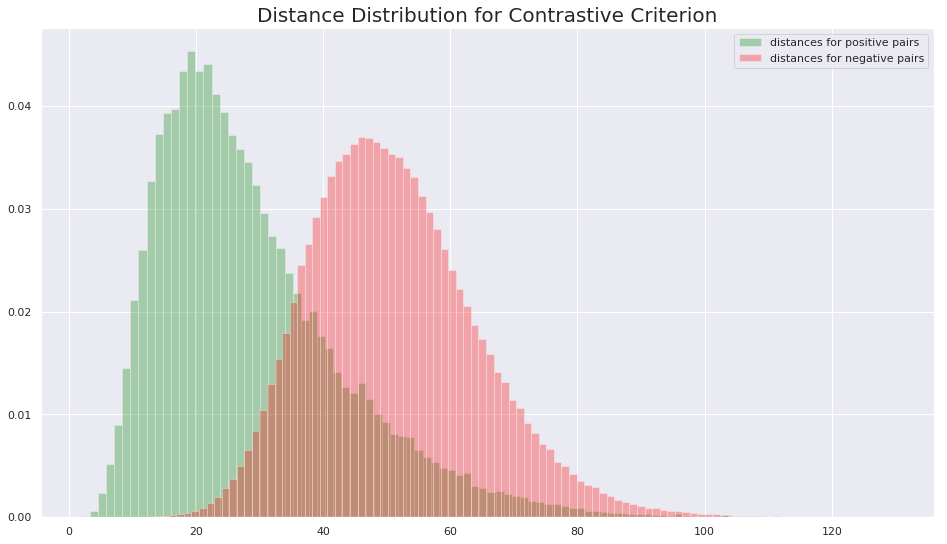

In [359]:
plot_dists(net,embeddings,labels,"Contrastive")

In [356]:
net = net_stencil(activations, bn=True)
print(net)
test = Experiment(performance=False)
print(test.criterion)
test.run(net)
embeddings = net.forward(X_val)

Linear 784 -> 98
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 98 -> 24
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 24 -> 10
LogSoftMax

ClassNLLCriterion


49715.0 449785.0
bhattacharyya coefficient = 0.7631759729371504


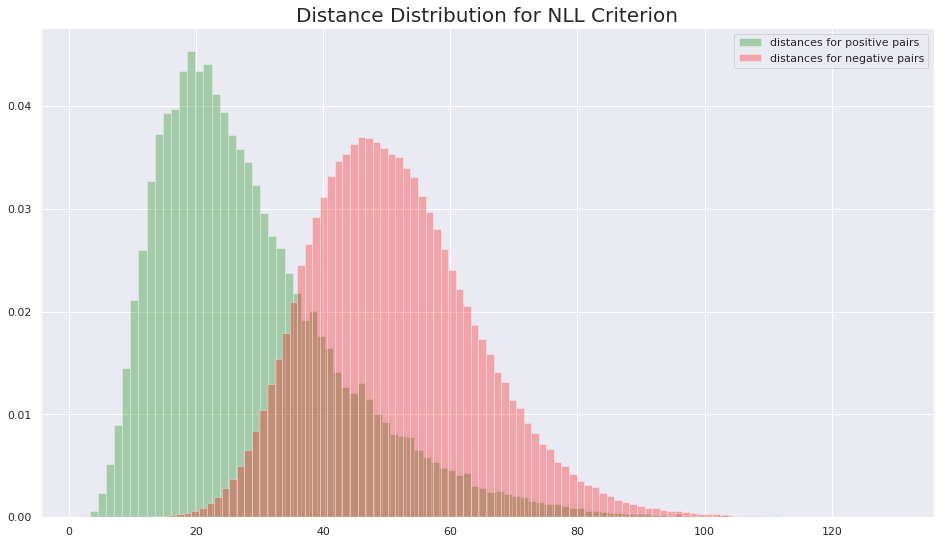

In [360]:
plot_dists(net,embeddings,labels,"NLL")